# Fitting a Neural Network to the Residuals of an erf Curve

In [4]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

### Helper Methods

In [5]:
class Helper:
    
    def __init__(self, nyt_data, mobility_data, population_data, density_data):
        self.nyt = nyt_data
        self.mobility = mobility_data
        self.population = population_data
        self.density = density_data
    
    def map_counties_to_deaths(self, counties):
        result = {}
        
        for i, row in counties.iterrows():
            county = int(row["FIPS"])
            
            c_data = self.nyt.loc[self.nyt["fips"] == int(county)]
            cum_deaths = 0
            for idx, row in c_data.iterrows(): cum_deaths += row["deaths"]
                
            result[county] = cum_deaths
        
        return result
    
    def construct_training_data(self, predictions, prediction_dates, training_cutoff, case_lag, size_cutoff, size_dict):
        training_data_s = pd.DataFrame()
        training_data_s["days_past_data"] = 0
        training_data_s["lag_cases"] = 0
        training_data_s["mobility"] = 0
        training_data_s["prop_60plus"] = 0
        training_data_s["pop_density"] = 0
        training_data_s["residual"] = 0
        
        training_data_l = pd.DataFrame()
        training_data_l["days_past_data"] = 0
        training_data_l["lag_cases"] = 0
        training_data_l["mobility"] = 0
        training_data_l["prop_60plus"] = 0
        training_data_l["pop_density"] = 0
        training_data_l["residual"] = 0
        
        training_data_l2 = pd.DataFrame()
        training_data_l2["days_past_data"] = 0
        training_data_l2["lag_cases"] = 0
        training_data_l2["mobility"] = 0
        training_data_l2["prop_60plus"] = 0
        training_data_l2["pop_density"] = 0
        training_data_l2["residual"] = 0
        
        for idx, row in predictions.iterrows():        
            fips = int(row["id"][11:])
            date = row["id"][:10]

            if not date in prediction_dates: continue

            print(row["id"], end='\r', flush=True)

            prediction = float(row["50"])
            try: actual = int(self.nyt.loc[self.nyt["fips"] == fips].loc[self.nyt["date"] == date]["deaths"])
            except TypeError as e: continue

            residual = prediction - actual
            
            if residual > 1000 or residual < -1000:
                print("Large residual found!")
                print(fips, date)
                print(residual)
                print()

            delta_time = (datetime.datetime.fromisoformat(date) - training_cutoff).days

            lag_date = datetime.datetime.fromisoformat(date) - datetime.timedelta(days = case_lag)
            try: lag_cases = int(self.nyt.loc[self.nyt["fips"] == fips].loc[self.nyt["date"] == lag_date.isoformat()[:10]]["cases"])
            except TypeError as e: lag_cases = 0

            try: mobil = int(self.mobility.loc[self.mobility["fips"] == fips].loc[self.mobility["date"] == date]["m50"])
            except TypeError as e: continue

            p_row = self.population.loc[self.population["FIPS"] == fips]
            plus60 = float(p_row["60plus"]) / float(p_row["total_pop"])

            dens = float(self.density.loc[self.density["County FIPS"] == fips]["2010 Density per square mile of land area - Population"])
            
            cumulative_deaths = size_dict[fips]
            
            if cumulative_deaths >= size_cutoff and not fips == 36061:
                training_data_l.loc[len(training_data_l)] = [delta_time, lag_cases, mobil, plus60, dens, residual]
            elif not fips == 36061:
                training_data_s.loc[len(training_data_s)] = [delta_time, lag_cases, mobil, plus60, dens, residual]

        return training_data_l, training_data_s, training_data_l2
    
    def construct_input(self, train, pred_dates, train_cutoff, lag_per):
        c = pd.DataFrame()
        c["days_past_data"] = 0
        c["lag_cases"] = 0
        c["mobility"] = 0
        c["prop_60plus"] = 0
        c["pop_density"] = 0
        c["residual"] = 0

        for idx, row in train.iterrows():        
            fips = row["fips"]
            date = row["date"]

            if not date in pred_dates: continue

            prediction = float(row["50"])
            try: actual = int(self.nyt.loc[self.nyt["fips"] == fips].loc[self.nyt["date"] == date]["deaths"])
            except TypeError as e: continue

            residual = prediction - actual

            delta_time = (datetime.datetime.fromisoformat(date) - train_cutoff).days

            lag_date = datetime.datetime.fromisoformat(date) - datetime.timedelta(days = lag_per)
            try: lag_cases = int(self.nyt.loc[self.nyt["fips"] == fips].loc[self.nyt["date"] == lag_date.isoformat()[:10]]["cases"])
            except TypeError as e:
                #print("Lag cases not found:", fips, lag_date.isoformat()[:10])
                lag_cases = 0

            try: mobil = int(self.mobility.loc[self.mobility["fips"] == fips].loc[self.mobility["date"] == date]["m50"])
            except TypeError as e:
                #print("Mobility not found:", fips)
                continue

            p_row = self.population.loc[self.population["FIPS"] == fips]
            plus60 = float(p_row["60plus"]) / float(p_row["total_pop"])

            dens = float(self.density.loc[self.density["County FIPS"] == fips]["2010 Density per square mile of land area - Population"])

            c.loc[len(c)] = [delta_time, lag_cases, mobil, plus60, dens, residual]
        
        return c

    
class ResidualNN:
    
    def __init__(self, training_data, history_len, target_len, STEP, TRAIN_SPLIT, BATCH_SIZE, BUFFER_SIZE):
        data = training_data.values
        self.mean = data.mean(axis=0)
        self.stddev = data.std(axis=0)
        self.data = (data-self.mean)/self.stddev
                
        self.history = history_len
        self.target = target_len
        self.STEP = STEP
        self.TRAIN_SPLIT = TRAIN_SPLIT
        self.BATCH_SIZE = BATCH_SIZE
        self.BUFFER_SIZE = BUFFER_SIZE
        
        x_train, y_train = self.multivariate_data(0, TRAIN_SPLIT)
        x_val, y_val = self.multivariate_data(TRAIN_SPLIT, None)
        
        train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        self.train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

        val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
        self.val_data = val_data.batch(BATCH_SIZE).repeat()
        
        self.init_model(x_train)
        
    def init_model(self, x_train):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]))
        model.add(tf.keras.layers.LSTM(16, activation='relu'))
        model.add(tf.keras.layers.Dense(self.target))
        model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
        
        self.model = model
    
    # From TensorFlow website
    def multivariate_data(self, start_index, end_index):
        data = []
        labels = []

        start_index = start_index + self.history
        if end_index is None:
            end_index = len(self.data) - self.target

        for i in range(start_index, end_index):
            indices = range(i-self.history, i, self.STEP)
            data.append(self.data[indices])
            labels.append(self.data[:, -1][i:i+self.target])

        return np.array(data), np.array(labels)

    def fit(self):
        return self.model.fit(
            self.train_data, epochs=10, steps_per_epoch=200, validation_data=self.val_data, validation_steps=50
        )
    
    def plot_training_loss(self, history):
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(loss))

        plt.figure()

        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()
        
    def model_input_array(self, input_data):
        data = []
    
        start_index = self.history
        end_index = len(input_data)

        for i in range(start_index, end_index):
            indices = range(i-self.history, i, self.STEP)
            data.append(input_data[indices])

        return np.array(data)
    
    def adjust_erf(self, final_pred_dates, predictions, residuals):
        ids, i10, i20, i30, i40, i50, i60, i70, i80, i90, dates, fipss = [], [], [], [], [], [], [], [], [], [], [], []

        for i, date in enumerate(final_pred_dates):
            erf_row = predictions.loc[predictions["date"] == date]
            dates.append(date)
            fipss.append(int(erf_row["fips"]))
            ids.append(date + "-" + str(int(erf_row["fips"])))

            i10.append(float(erf_row["10"]) - residuals[i])
            i20.append(float(erf_row["20"]) - residuals[i])
            i30.append(float(erf_row["30"]) - residuals[i])
            i40.append(float(erf_row["40"]) - residuals[i])
            i50.append(float(erf_row["50"]) - residuals[i])
            i60.append(float(erf_row["60"]) - residuals[i])
            i70.append(float(erf_row["70"]) - residuals[i])
            i80.append(float(erf_row["80"]) - residuals[i])
            i90.append(float(erf_row["90"]) - residuals[i])

        return pd.DataFrame(data={"id":ids, "10":i10, "20":i20, "30":i30, "40":i40, "50":i50, "60":i60, "70":i70, "80":i80, "90":i90, "date":dates, "fips":fipss})
    
    def predict_one_county(self, fips, train_erf, pred_erf, helper, train_cutoff, lag_per, erf_dates, pred_dates):
        c_pred = pred_erf.loc[pred_erf["fips"] == fips]
        c_train = train_erf.loc[train_erf["fips"] == fips]
        
        c_input = helper.construct_input(train=c_train, pred_dates=erf_dates, train_cutoff=train_cutoff, lag_per=lag_per)
        
        c_data = c_input.values
        c_data = (c_data-self.mean)/self.stddev
        
        x = self.model_input_array(c_data)
        
        try: 
            nn_predictions = self.model.predict(x)
            adjusted_nn_residuals = (nn_predictions[-1] * self.stddev[-1] + self.mean[-1])
            #print(nn_predictions)

            p_df = self.adjust_erf(pred_dates, c_pred, adjusted_nn_residuals)

            return p_df
        except ValueError as e:
            # Not enough data to make a prediction with the neural net, so just use the erf curve
            return c_pred


## Constructing the Dataset

In [6]:
erf = pd.read_csv("curve_for_residuals_train.csv")
nyt_data = pd.read_csv("../data/us/covid/nyt_us_counties_daily.csv")
mobility = pd.read_csv("../data/us/mobility/DL-us-mobility-daterow.csv")
population = pd.read_csv("../data/us/demographics/county_populations.csv")
density = pd.read_csv("../data/us/demographics/county_land_areas.csv", encoding="cp1252")

In [54]:
erf.head(0)

,id,10,20,30,40,50,60,70,80,90


In [55]:
nyt_data.head(0)

,fips,date,county,state,cases,deaths


In [56]:
mobility.head(0)

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index


In [57]:
population.head(0)

,FIPS,total_pop,60plus


In [58]:
density.head(0)

,County FIPS,County Name,Area in square miles - Total area,Area in square miles - Land area,2010 Density per square mile of land area - Population,2010 Density per square mile of land area - Housing units


In [7]:
helper = Helper(nyt_data, mobility, population, density)

In [9]:
erf_train_cutoff = datetime.datetime.fromisoformat("2020-05-10")
erf_pred_dates = ["2020-05-11", "2020-05-12", "2020-05-13", "2020-05-14", "2020-05-15", "2020-05-16", "2020-05-17", \
                  "2020-05-18", "2020-05-19", "2020-05-20", "2020-05-21", "2020-05-22", "2020-05-23", "2020-05-24"]

c_map = helper.map_counties_to_deaths(pd.read_csv("../data/us/processing_data/fips_key.csv", encoding="cp1252"))

training_data_l, training_data_s, training_data_ny = helper.construct_training_data(
    predictions = erf, prediction_dates = erf_pred_dates, 
    training_cutoff = erf_train_cutoff, case_lag = 14,
    size_cutoff = 200,
    size_dict = c_map
)

In [61]:
training_data_l.describe()

,days_past_data,lag_cases,mobility,prop_60plus,pop_density,residual
count,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000
mean,21.500000,173.118421,1.171053,0.205543,2289.075000,-4.756656
std,3.453947,221.855510,1.360133,0.026833,2496.188628,10.679822
min,16.000000,0.000000,0.000000,0.144000,247.300000,-98.630000
25%,18.750000,69.750000,0.000000,0.185923,915.975000,-8.067500
50%,21.500000,119.500000,1.000000,0.204894,1557.950000,-3.355000
75%,24.250000,202.750000,2.000000,0.223473,2470.100000,0.112500
max,27.000000,2155.000000,7.000000,0.290816,13731.400000,29.670000


In [62]:
training_data_s.describe()

,days_past_data,lag_cases,mobility,prop_60plus,pop_density,residual
count,30328.000000,30328.000000,30328.000000,30328.000000,30328.000000,30328.000000
mean,21.514343,4.437022,6.947639,0.240562,180.745503,-0.144326
std,3.451465,14.689618,13.856829,0.050336,579.616541,0.775859
min,16.000000,0.000000,0.000000,0.058129,1.000000,-21.000000
25%,19.000000,0.000000,3.000000,0.209697,28.200000,0.000000
50%,22.000000,0.000000,6.000000,0.238520,56.200000,0.000000
75%,25.000000,3.000000,9.000000,0.267719,132.000000,0.000000
max,27.000000,897.000000,687.000000,0.641828,17179.200000,13.080000


## Training a Recurrent Neural Network

In [10]:
large_NN = ResidualNN(
    training_data = training_data_l.sample(frac=1), # shuffle input data
    history_len = 7, target_len = 21,
    STEP = 1, TRAIN_SPLIT = 650, BATCH_SIZE = 64, BUFFER_SIZE = 10000
)

In [11]:
small_NN = ResidualNN(
    training_data = training_data_s.sample(frac=1),
    history_len = 10, target_len = 21,
    STEP = 1, TRAIN_SPLIT = 27000, BATCH_SIZE = 256, BUFFER_SIZE = 10000
)

In [12]:
large_history = large_NN.fit()

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 32ms/step - loss: 0.6118 - val_loss: 0.5537
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.6059 - val_loss: 0.5575
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.6008 - val_loss: 0.5628
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5970 - val_loss: 0.5702
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5859 - val_loss: 0.5750
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5798 - val_loss: 0.5834
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5751 - val_loss: 0.5833
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5750 - val_loss: 0.5896
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.5673 - val_loss: 0.5945
Epoch 10/10
200/200 [===========================

In [13]:
small_history = small_NN.fit()

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 9s 44ms/step - loss: 0.2661 - val_loss: 0.2262
Epoch 2/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2454 - val_loss: 0.2252
Epoch 3/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2445 - val_loss: 0.2243
Epoch 4/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2444 - val_loss: 0.2259
Epoch 5/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2442 - val_loss: 0.2241
Epoch 6/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2430 - val_loss: 0.2230
Epoch 7/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2439 - val_loss: 0.2230
Epoch 8/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2438 - val_loss: 0.2233
Epoch 9/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2441 - val_loss: 0.2233
Epoch 10/10
200/200 [===========================

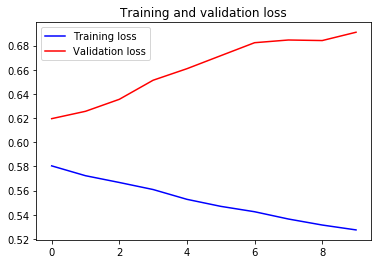

In [923]:
large_NN.plot_training_loss(large_history)

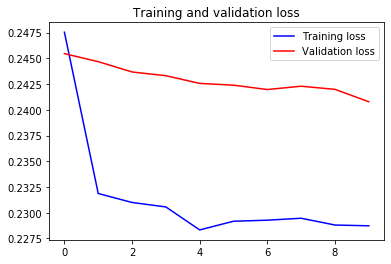

In [924]:
small_NN.plot_training_loss(small_history)

## Making a Prediction

Using the erf prediction for LA county, build an input dataset with external information and use the training neural net to predict residuals and adjust the baseline based on these predictions

In [71]:
erf_final = pd.read_csv("curve_for_residuals_predict.csv")

In [72]:
erf_final["fips"] = 0
erf_final["date"] = ""

for i, row in erf_final.iterrows():
    fips = int(row["id"][11:])
    date = row["id"][:10]
    erf_final.at[i, "fips"] = fips
    erf_final.at[i, "date"] = date

In [84]:
erf_final.head()

,id,10,20,30,40,50,60,70,80,90,fips,date
0,2020-04-01-10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10001,2020-04-01
1,2020-04-01-10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10003,2020-04-01
2,2020-04-01-10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10005,2020-04-01
3,2020-04-01-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001,2020-04-01
4,2020-04-01-1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1003,2020-04-01


In [74]:
erf["fips"] = 0
erf["date"] = ""

for i, row in erf.iterrows():
    fips = int(row["id"][11:])
    date = row["id"][:10]
    erf.at[i, "fips"] = fips
    erf.at[i, "date"] = date

In [85]:
erf.head()

,id,10,20,30,40,50,60,70,80,90,fips,date
0,2020-04-01-10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10001,2020-04-01
1,2020-04-01-10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10003,2020-04-01
2,2020-04-01-10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10005,2020-04-01
3,2020-04-01-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001,2020-04-01
4,2020-04-01-1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1003,2020-04-01


In [794]:
final_pred_dates = ["2020-05-10", "2020-05-11", "2020-05-12", "2020-05-13", "2020-05-14", "2020-05-15", "2020-05-16", \
                    "2020-05-17", "2020-05-18", "2020-05-19", "2020-05-20", "2020-05-21", "2020-05-22", "2020-05-23", \
                    "2020-05-24", "2020-05-25", "2020-05-26", "2020-05-27", "2020-05-28"]

erf_pred_dates = ["2020-04-26", "2020-04-27", "2020-04-28", "2020-04-29", "2020-04-30", "2020-05-01", "2020-05-02", \
                  "2020-05-03", "2020-05-04", "2020-05-05", "2020-05-06", "2020-05-07", "2020-05-08", "2020-05-09"]

f = 25025

la = large_NN.predict_one_county(f, erf, erf_final, helper, datetime.datetime.fromisoformat("2020-04-16"), 7, erf_pred_dates, final_pred_dates)


In [795]:
la_actual = nyt_data.loc[nyt_data["fips"] == f]

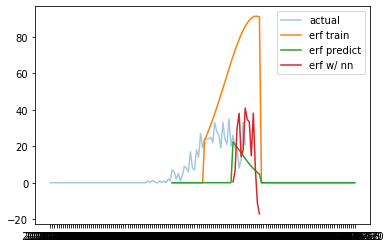

In [796]:
fig, ax = plt.subplots()
ax.plot('date', 'deaths', data=la_actual, label="actual", alpha=0.4)
ax.plot('date', '50', data=erf.loc[erf["fips"] == f], label="erf train")
ax.plot('date', '50', data=erf_final.loc[erf_final["fips"] == f], label="erf predict")
ax.plot('date', '50', data=la, label="erf w/ nn")
plt.legend()
plt.show()

## Generating a Submission

In [94]:
fips_list = pd.read_csv("../data/us/processing_data/fips_key.csv", encoding="cp1252")
fips_list.head()

,FIPS,MSA/PMSA NECMA,ST,COUNTY
0,1001,5240,AL,Autauga County
1,1003,5160,AL,Baldwin County
2,1005,0,AL,Barbour County
3,1007,0,AL,Bibb County
4,1009,1000,AL,Blount County


In [95]:
sample = pd.read_csv("../sample_submission.csv")

In [96]:
final_pred_dates = ["2020-05-25", "2020-05-26", "2020-05-27", "2020-05-28", "2020-05-29", "2020-05-30", "2020-05-31", \
                     "2020-06-01", "2020-06-02", "2020-06-03", "2020-06-04", "2020-06-05", "2020-06-06", "2020-06-07", \
                     "2020-06-08", "2020-06-09", "2020-06-10", "2020-06-11", "2020-06-12", "2020-06-13", "2020-06-14"]

erf_pred_dates = ["2020-05-11", "2020-05-12", "2020-05-13", "2020-05-14", "2020-05-15", "2020-05-16", "2020-05-17", \
                  "2020-05-18", "2020-05-19", "2020-05-20", "2020-05-21", "2020-05-22", "2020-05-23", "2020-05-24"]

In [97]:
print(str(datetime.datetime.now())+"\n")

predictions = pd.DataFrame(columns=["id", "10", "20", "30", "40", "50", "60", "70", "80", "90", "date", "fips"])
submission = sample.copy()

for idx, row in fips_list.iterrows():
    county = int(row["FIPS"])
    print("County " + str(county) + "...", end='\r', flush=True)
    c_row = nyt_data.loc[nyt_data["fips"] == county]
    
    # Construct the input dataframe
    cum_deaths = 0
    for i, item in c_row.iterrows():
        cum_deaths += int(item["deaths"])
    
    if cum_deaths > 200:
        pred = large_NN.predict_one_county(county, erf, erf_final, helper, datetime.datetime.fromisoformat("2020-04-25"), 7, erf_pred_dates, final_pred_dates)
    else:
        pred = small_NN.predict_one_county(county, erf, erf_final, helper, datetime.datetime.fromisoformat("2020-04-25"), 7, erf_pred_dates, final_pred_dates)
    
    predictions = predictions.append(pred)
    
    for i, row in pred.iterrows():
        ss_location = submission.index[submission["id"] == row["id"]][0]
        submission.at[ss_location] = row.drop(["date", "fips"])

print("\n" + str(datetime.datetime.now()))

2020-05-25 18:44:00.826472

County 78030...
2020-05-25 21:29:57.906976


In [98]:
submission["10"] = submission["10"].apply(lambda x: x if x >= 1 else 0)
submission["20"] = submission["20"].apply(lambda x: x if x >= 1 else 0)
submission["30"] = submission["30"].apply(lambda x: x if x >= 1 else 0)
submission["40"] = submission["40"].apply(lambda x: x if x >= 1 else 0)
submission["50"] = submission["50"].apply(lambda x: x if x >= 1 else 0)
submission["60"] = submission["60"].apply(lambda x: x if x >= 1 else 0)
submission["70"] = submission["70"].apply(lambda x: x if x >= 1 else 0)
submission["80"] = submission["80"].apply(lambda x: x if x >= 1 else 0)
submission["90"] = submission["90"].apply(lambda x: x if x >= 1 else 0)

In [99]:
submission.to_csv("rnn_checkpoint3.csv", index=False)

7 day lag loss: 0.15362227727272215\
14 day lag loss: 0.15426985839645113

### Convert to a Better Format

In [3]:
sample = pd.read_csv("../sample_submission.csv")

In [945]:
sample.head()

,id,10,20,30,40,50,60,70,80,90
0,2020-04-01-10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-04-01-10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-04-01-10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-04-01-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-04-01-1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [946]:
predictions_fixed = sample.copy()

for i, row in predictions.iterrows():
    this_id = row["id"]
    print(this_id, end='\r', flush=True)
    ss_location = predictions_fixed.index[predictions_fixed["id"] == this_id][0]
    predictions_fixed.at[ss_location] = row

In [947]:
predictions_fixed.to_csv("../checkpoint2_submissions/residual_nn_predictions_final.csv", index=False)

In [4]:
sample.sort_values("id")

,id,10,20,30,40,50,60,70,80,90
0,2020-04-01-10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-04-01-10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-04-01-10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-04-01-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-04-01-1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
293288,2020-06-30-9007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293289,2020-06-30-9009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293290,2020-06-30-9011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293291,2020-06-30-9013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
sample

,id,10,20,30,40,50,60,70,80,90
0,2020-04-01-10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-04-01-10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-04-01-10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-04-01-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-04-01-1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
293288,2020-06-30-9007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293289,2020-06-30-9009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293290,2020-06-30-9011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293291,2020-06-30-9013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
large_NN.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 32)             4992      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 21)                357       
Total params: 8,485
Trainable params: 8,485
Non-trainable params: 0
_________________________________________________________________


In [37]:
weights = large_NN.model.get_layer(index=0).get_weights()[0]

In [41]:
for array in weights: print(sum(array))

0.09824276575818658
-3.4621556331403553
-3.8588445223867893
1.266611448256299
0.8226324850402307
-0.8523726644925773


In [42]:
sweights = small_NN.model.get_layer(index=0).get_weights()[0]

In [43]:
for array in sweights: print(sum(array))

0.6347071412019432
1.2032850568648428
1.2784321529325098
-2.45458557526581
2.463846720289439
0.9964779700385407
